# Biomechanical simulation

Let's simulate the response of a biomechanical model to some input, without training a neural network to produce the input.

In particular, we'll apply a constant stimulation to one of six "muscles" which move the joints of a two-jointed arm.

??? Info "Types of biomechanical models"
    Here are three representative biomechanical models:

    ![](biomechanics.svg){: style="width:50%; margin:auto; display:block;"}
    
    On the left is the *point mass*, which was the first and simplest model we [trained](/feedbax/examples/0_train_simple) a neural network to control. It's controlled by linear $x$ and $y$ forces, which accelerate the point mass according to Newton's second law of motion.
    
    In the middle is a two-joint arm (i.e. double pendulum) which is controlled by applying torques directly to its joints. Note that the "shoulder" joint (at the bottom) is rotational, but its position is fixed.
    
    On the right is also a two-joint arm, except it's controlled by stimulating six muscles to contract; their contraction results in torques on the joints. This is the model of interest to the current example. Note that the shapes/dimensions of the muscles seen in this diagram are only for ease of visualization—the actual model is a low-dimensional simplification.

## Setup

First, import everything we need and create a random key.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import diffrax as dfx
import equinox as eqx
import jax.numpy as jnp
import jax.random as jr

from feedbax import ModelInput
from feedbax.iterate import Iterator
from feedbax.mechanics import Mechanics
from feedbax.mechanics.muscle import ActivationFilter, todorov_li_2004_virtualmuscle
from feedbax.mechanics.plant import MuscledArm
from feedbax.mechanics.skeleton.arm import TwoLinkArm
from feedbax.plot import plot_joint_pos_trajectory

In [2]:
seed = 1234
key = jr.PRNGKey(seed)
key_init, key_eval = jr.split(key)

## Build the model

In [3]:
tau = 0.01  # muscle activation/deactivation time constant
dt = 0.01
solver_type = dfx.Euler

plant = MuscledArm(
    skeleton=TwoLinkArm(),
    muscle_model=todorov_li_2004_virtualmuscle(),
    activator=ActivationFilter(
        tau_act=tau,
        tau_deact=tau,
    ),
)

mechanics = Mechanics(plant, dt=dt, solver_type=solver_type)

Now, instead of using `mechanics` as [part of a larger model](/feedbax/examples/1_train) that includes a neural network, we'll wrap it directly in `Iterator` to turn it into a model over $N$ time steps.

In [4]:
t0 = 0
t1 = 1
n_steps = int((t1 - t0) / dt)

model = Iterator(mechanics, n_steps)

## Simulate an arm movement

We need an initial state for the arm. We'll get a default state and then use [surgery](/feedbax/examples/pytrees#immutability-in-feedbax-performing-surgery) to make a state where the joints are at specific starting angles. 

In [5]:
# Get a default initial state.
default_state = model.init(key=key_init)

# Change the initial joint angles.
init_state = eqx.tree_at(
    lambda state: state.plant.skeleton.angle,
    default_state,
    jnp.array([jnp.pi / 5, jnp.pi / 3]),
)

Now we define the input/stimulation to each of the six muscles. We'll use constant stimulation over the whole trial, so we'll define the stimulation for a single time step, and then broadcast it across an extra dimension of size `n_steps - 1`.

In [6]:
# Constant input to each of the six "muscles".
# Try changing these values to see how the arm moves!
muscle_input = jnp.array([0., 0., 0.15, 0., 0., 0.0])

# The `Iterator` expects `n_steps - 1` of inputs
muscle_inputs = jnp.broadcast_to(
    muscle_input,
    (n_steps - 1, 6),
)

Run the simulation. We just need to pass the input and initial state to the model, along with a random key.

!!! Bug "ModelInput"
    Currently, the inputs to a model have to be wrapped in `ModelInput`, as seen below. This is inconvenient and I expect it will change soon. See [this GitHub issue](https://github.com/mlprt/feedbax/issues/12).

In [7]:
states = model(ModelInput(muscle_inputs, {}), init_state, key=key_eval)

Now we can plot the position of the arm over time. Normally, `states` only stores the *configuration state* of the skeleton—in this case, joint angles and angular velocities—as well as the *effector state*, which in this case is the Cartesian position and velocity of the *end* of the arm. 

To plot the position of all joints in the arm, we first need to obtain them by the *forward kinematics* computation. This is provided by the skeleton model, and it takes the skeleton's state as input. 

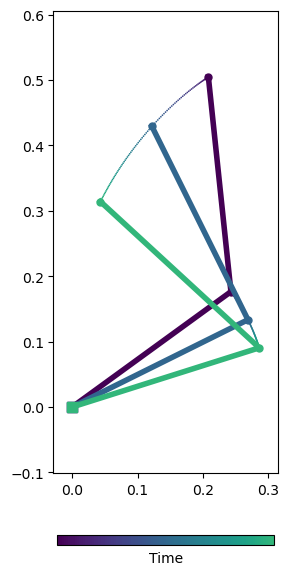

In [11]:
# We use `vmap` because `forward_kinematics` is only defined in terms of a single state, not a time series of states.
xy = eqx.filter_vmap(plant.skeleton.forward_kinematics)(states.plant.skeleton)

fig, ax = plot_joint_pos_trajectory(xy.pos, add_root=True, t0t1=(0,10))

In this case we've stimulated only the *monoarticular elbow flexor*, which contracts on the inside of the elbow and causes the arm to "curl inward". Note however that the shoulder joint also moves in response to the contraction of this elbow muscle—this is a demonstration that the segments of a limb are typically *not* independent, but interacting, as this model captures.